# Chemical space and its visualization

In [105]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
%matplotlib inline
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re
from rdkit.Chem import Draw

## Data preparation

In [8]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [9]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [10]:
# function for my descriptors
desc = [("n_rings", Chem.GetSSSR), ("n_heteroatoms", rdMolDescriptors.CalcNumHeteroatoms)]

In [70]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

In [71]:
with open("Epidermal_growth_factor_receptor_erbB1_IC50.csv") as inp:
    EGFR = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in EGFR:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "EGFR"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        m['scaf'] = True if Chem.MolToSmiles(scaffold(m["rdmol"])) == 'C1CCC(CC2CCCC3CCCCC32)CC1' else False
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])
        for i in desc:
            m[i[0]] = i[1](m["rdmol"])

In [14]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func},
             **{i[0]: i[1](m) for i in desc}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [113]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *EGFR), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", "scaf", *(f[0] for f in lip_func), *(i[0] for i in desc)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

df1 = pd.DataFrame((*drugbank[:1000], *EGFR[:1000]), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", "scaf", *(f[0] for f in lip_func), *(i[0] for i in desc)])
df1.reset_index(level=0, inplace=True)

## Common plots

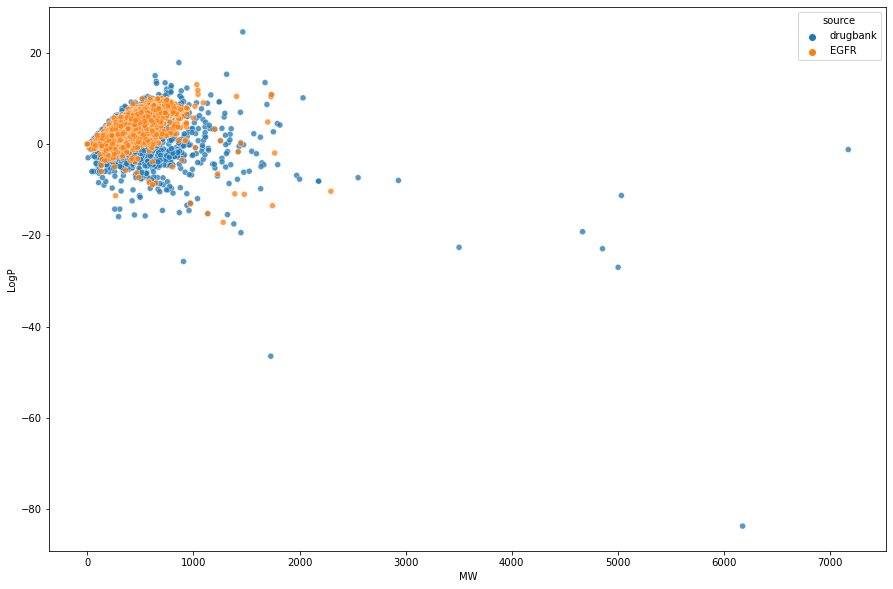

In [115]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

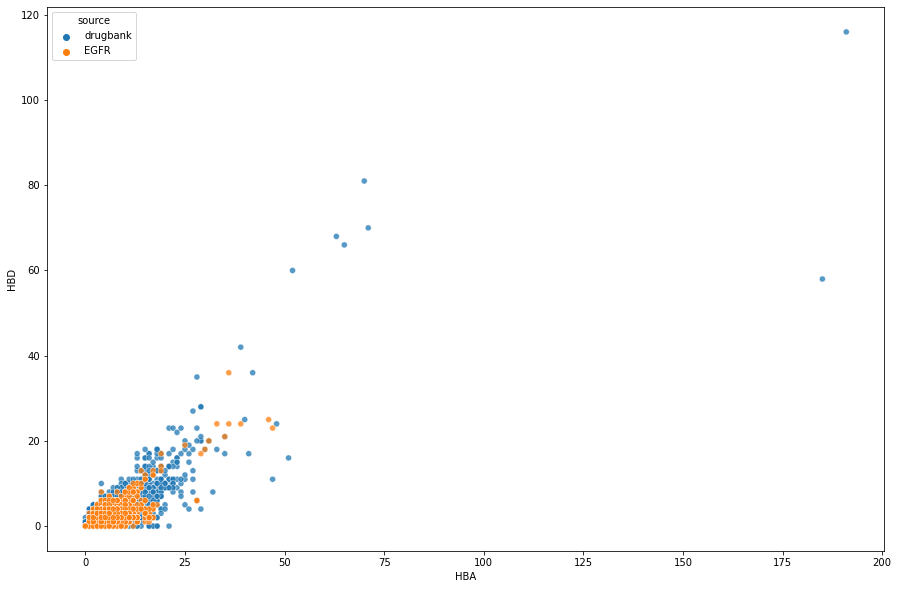

In [116]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

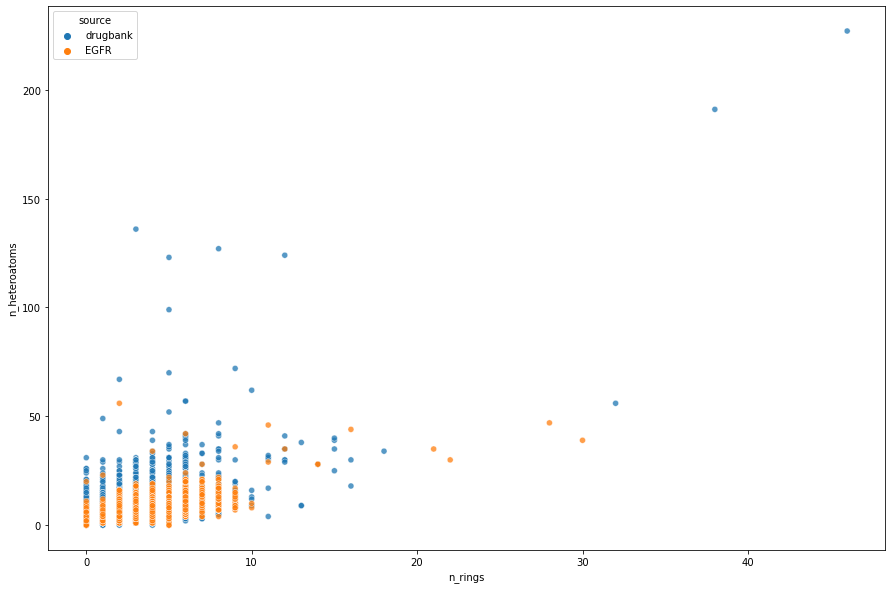

In [117]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="n_rings",
                      y="n_heteroatoms",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

[MQNs](https://dx.doi.org/10.1021/cn3000422)

In [118]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

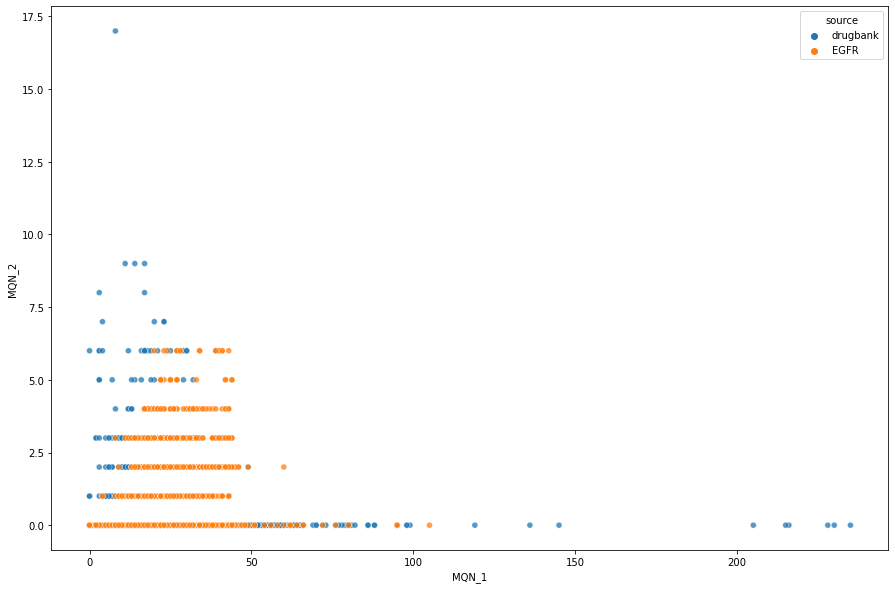

In [119]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## PCA

In [120]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

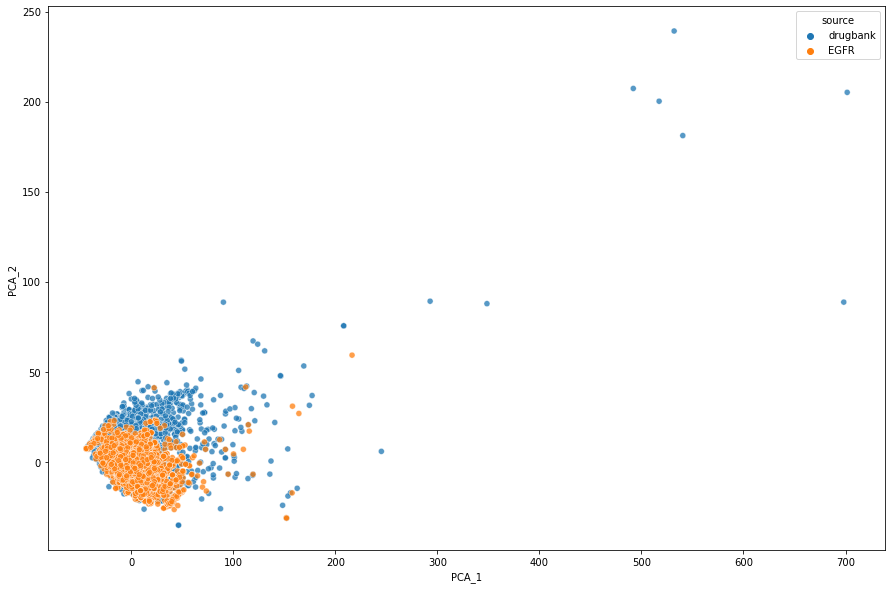

In [121]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Text(0.5, 0, 'PCA_3')

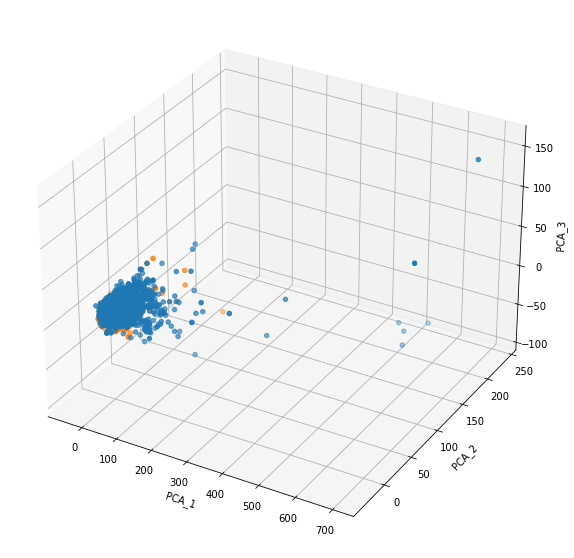

In [122]:
fig, ax = pyplot.subplots(figsize=(15,10), subplot_kw=dict(projection='3d'))

for i in df['source'].unique():
    ax.scatter( df['PCA_1'][df['source'] == i], 
                df['PCA_2'][df['source'] == i], 
                df['PCA_3'][df['source'] == i], 
                label = f'{i}')

ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')

#### Normalization

In [123]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

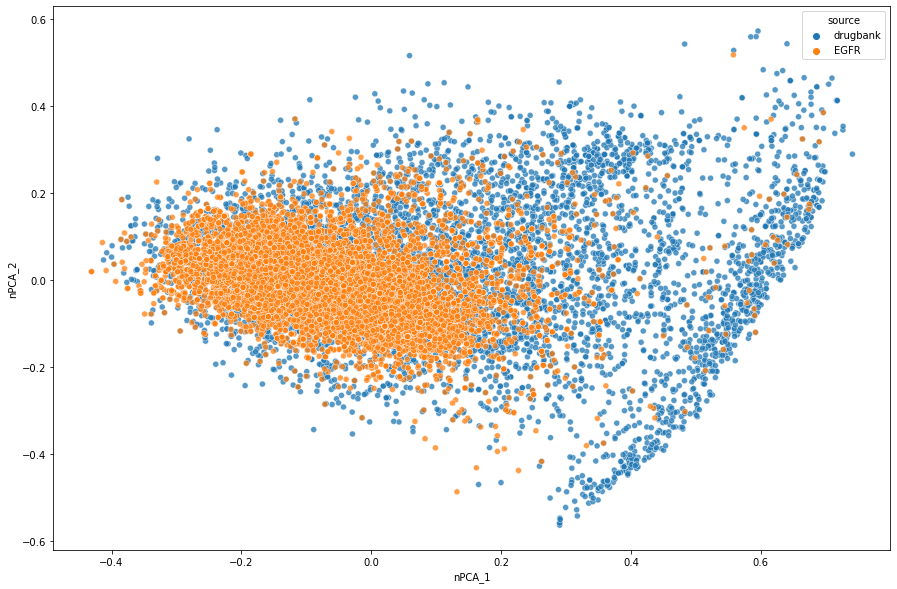

In [124]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Text(0.5, 0, 'nPCA_3')

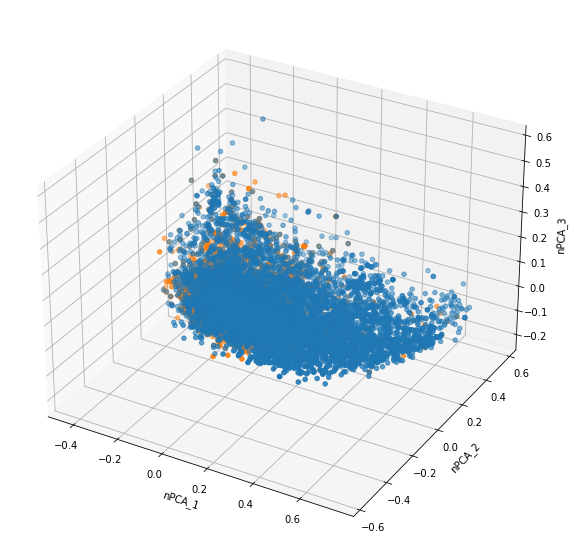

In [125]:
fig, ax = pyplot.subplots(figsize=(15,10), subplot_kw=dict(projection='3d'))

for i in df['source'].unique():
    ax.scatter( df['nPCA_1'][df['source'] == i], 
                df['nPCA_2'][df['source'] == i], 
                df['nPCA_3'][df['source'] == i], 
                label = f'{i}')

ax.set_xlabel('nPCA_1')
ax.set_ylabel('nPCA_2')
ax.set_zlabel('nPCA_3')

## MDS

In [126]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

MemoryError: Unable to allocate 440. MiB for an array with shape (21477, 21477) and data type bool

In [127]:
sparse_mat = distance.pdist(list(df1["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [128]:
df1 = df1.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

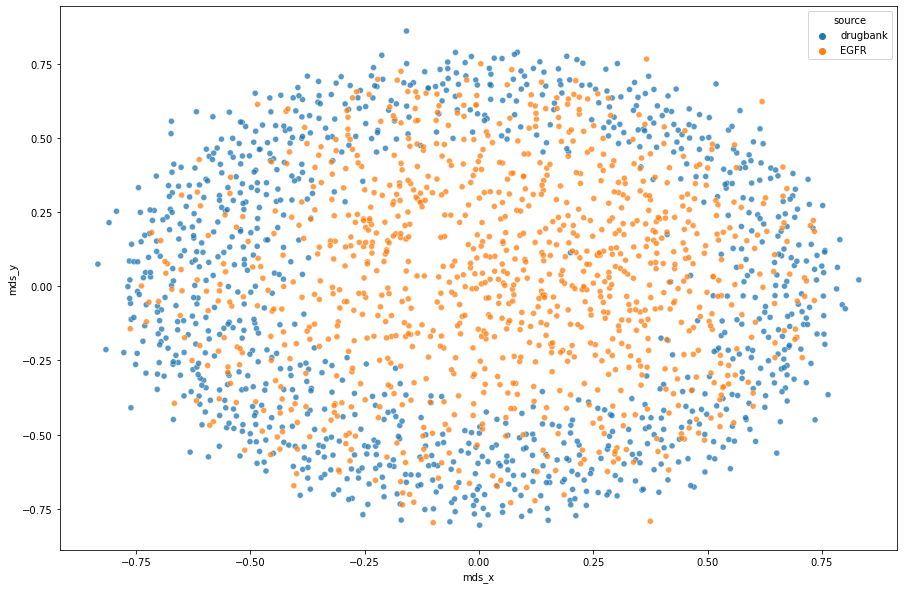

In [129]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df1,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## t-SNE

In [130]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [131]:
df1 = df1.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

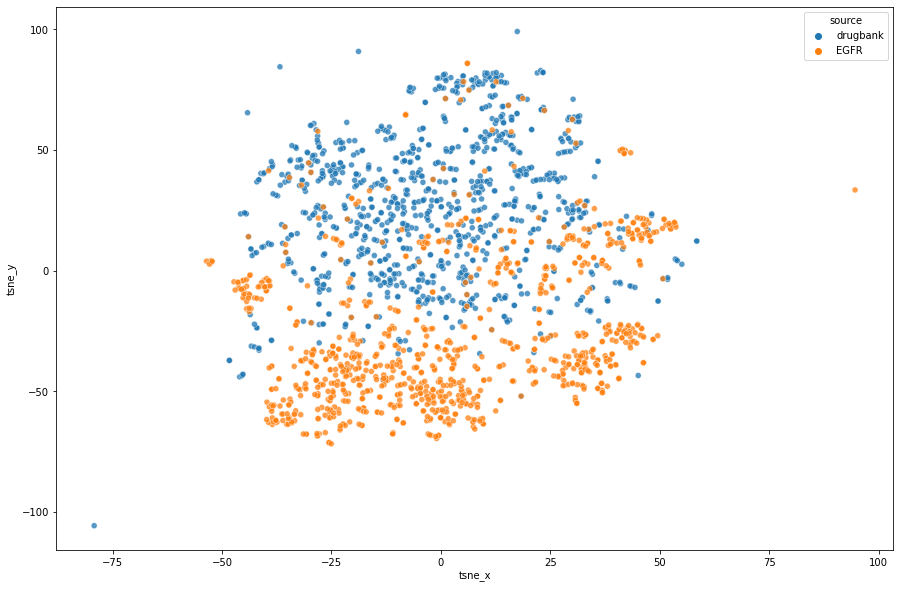

In [132]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df1,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## How can we use it?
### Use case 1: Diversity picker

In [133]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [134]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

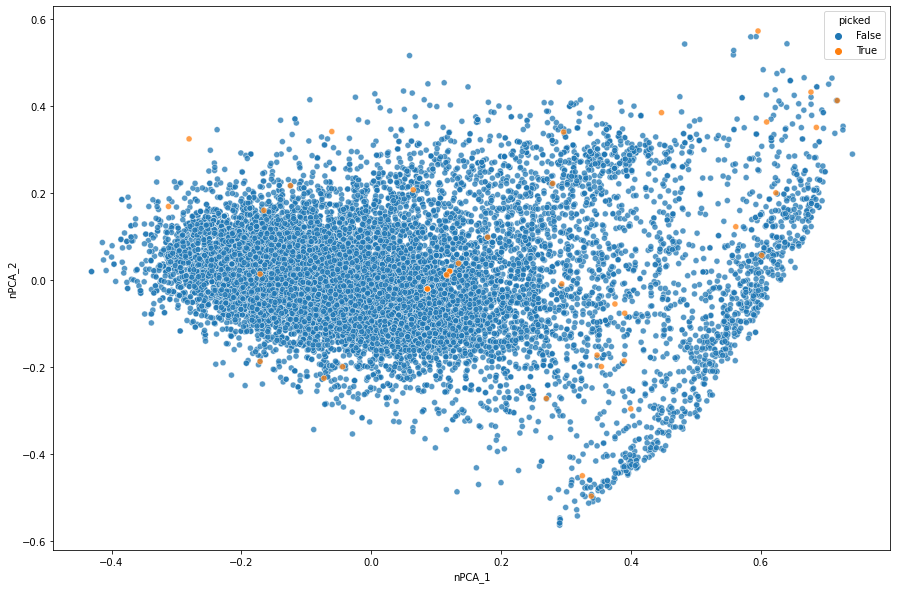

In [135]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

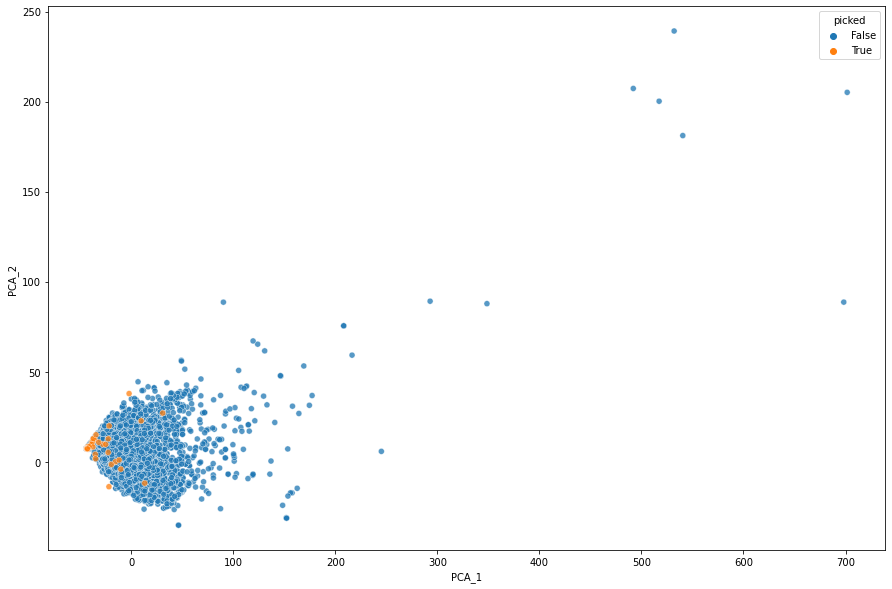

In [137]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1",
                      y="PCA_2",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Use case 2: Activities or descriptors

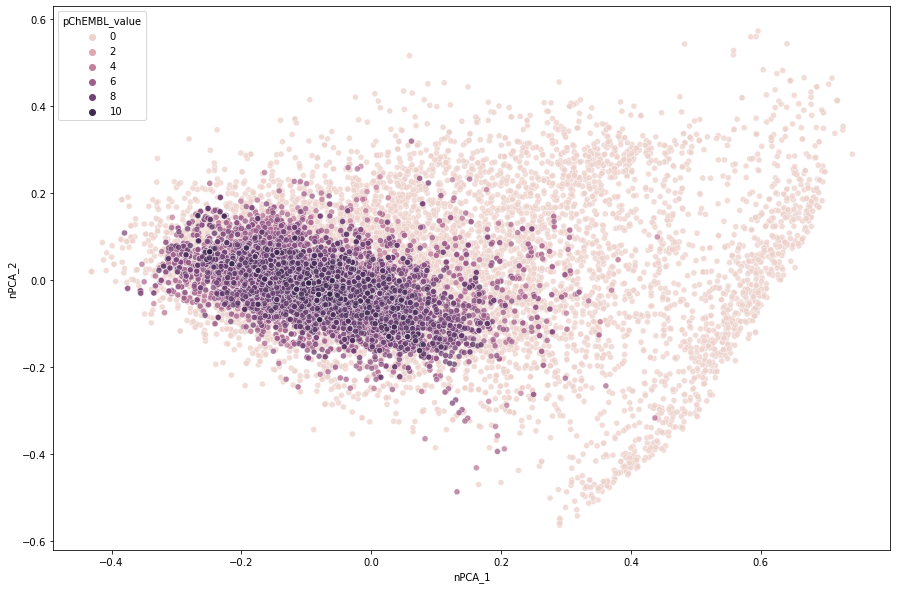

In [139]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

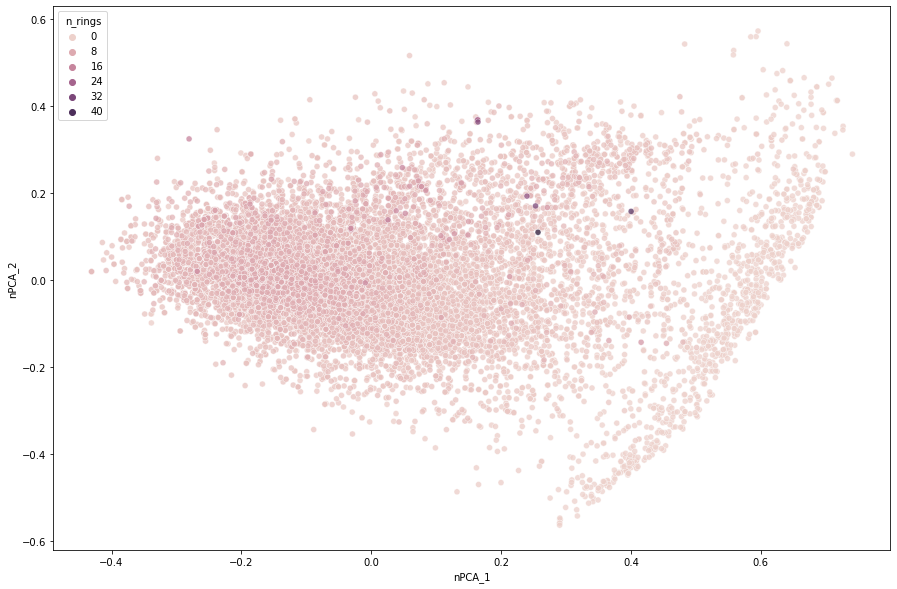

In [140]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("n_rings"),
                      hue="n_rings",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

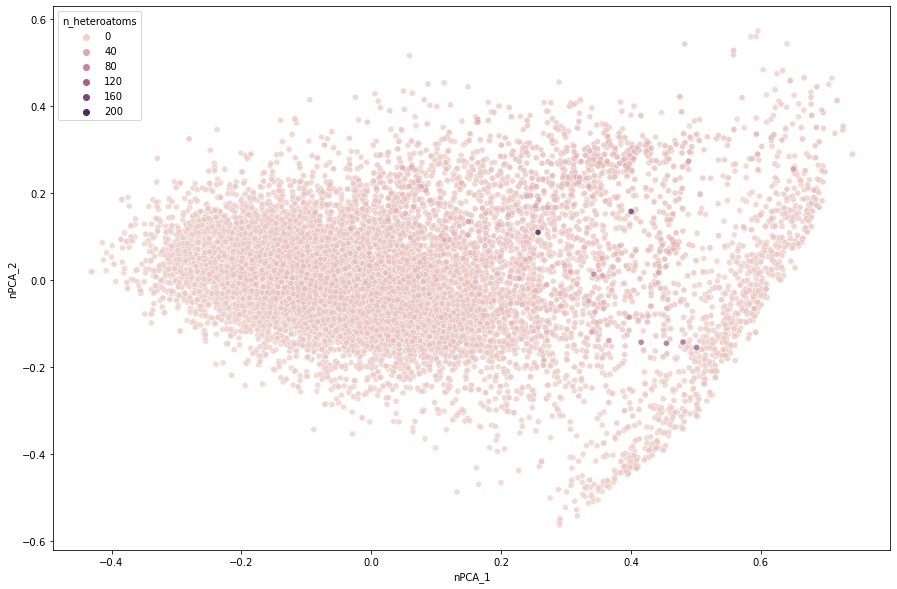

In [141]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("n_heteroatoms"),
                      hue="n_heteroatoms",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

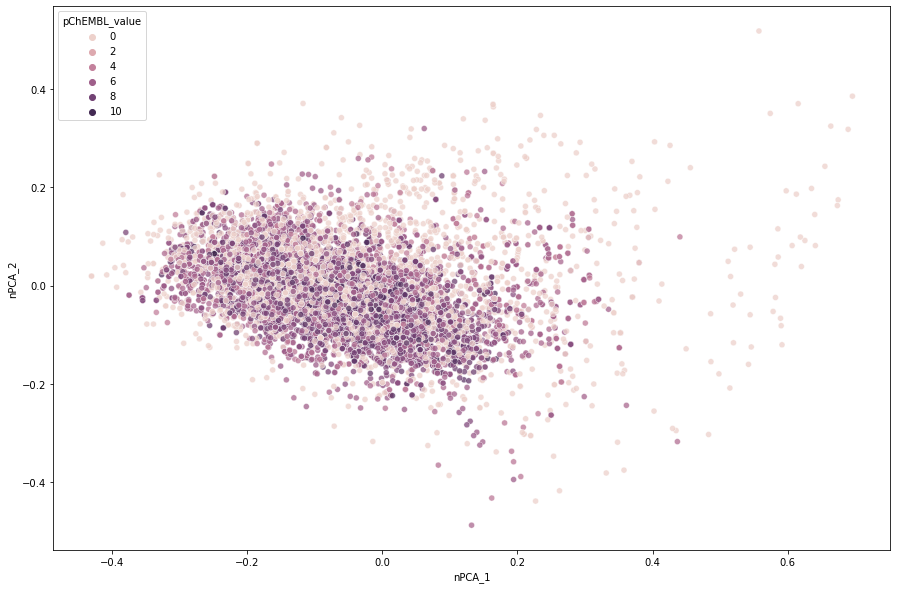

In [143]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "EGFR"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

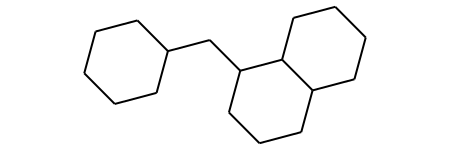

In [144]:
Chem.MolFromSmiles('C1CCC(CC2CCCC3CCCCC32)CC1')

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


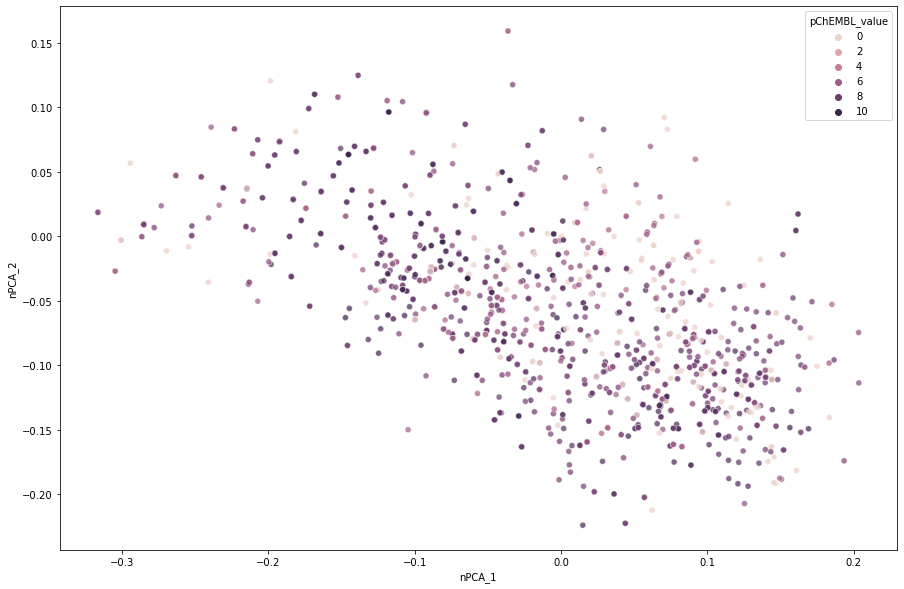

In [145]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "EGFR"][df.scaf == True],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

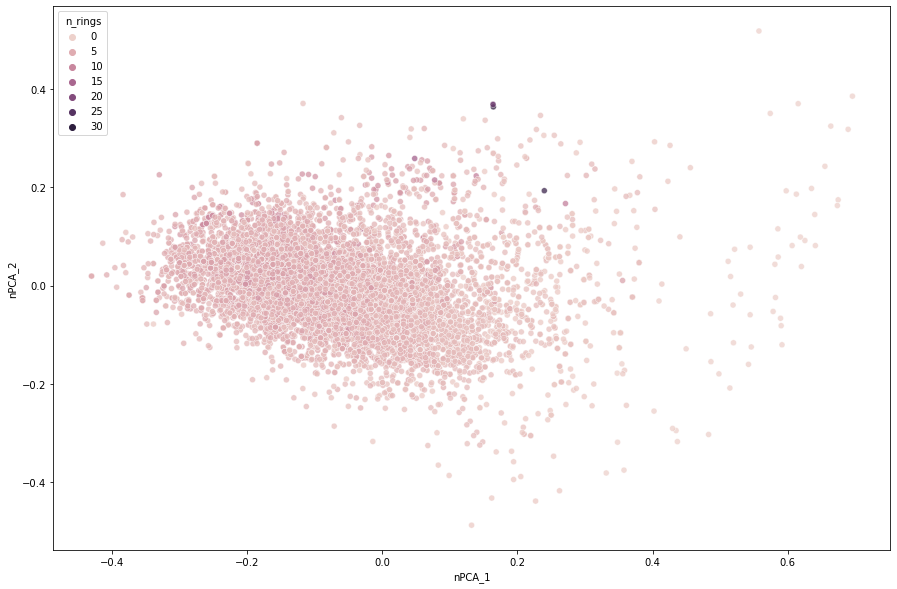

In [146]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "EGFR"],
                      hue="n_rings",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

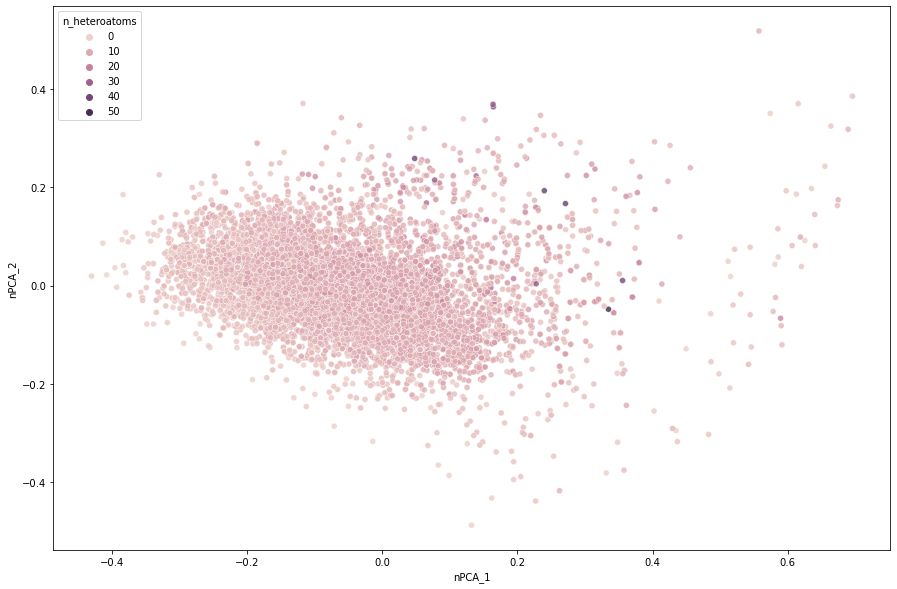

In [148]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "EGFR"],
                      hue="n_heteroatoms",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


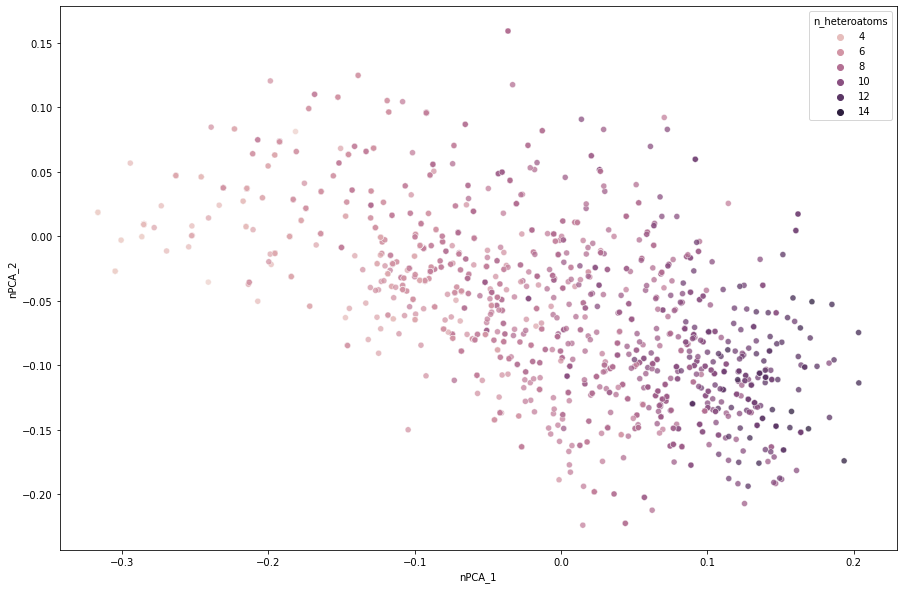

In [149]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "EGFR"][df.scaf == True],
                      hue="n_heteroatoms",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )